In [1]:
import pandas as pd
import numpy as np
import phik 
from phik.report import plot_correlation_matrix
from sklearn.preprocessing import LabelEncoder
import random
import torch
from tqdm.notebook import tqdm
from lightautoml.automl.presets.tabular_presets import TabularAutoML
from lightautoml.tasks import Task
from sklearn.metrics import mean_absolute_percentage_error as mape

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(1001)

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('train.csv', index_col=0)
df

,apartment_type,metro_station,minutes_to_metro,region,number_of_rooms,area,living_area,kitchen_area,floor,number_of_floors,renovation,price
index,,,,,,,,,,,,
0,Secondary,Ботанический сад,13,Moscow,3,52.89,25.0,12.6,3,10,European-style renovation,18084832.0
1,New building,Нагатинская,23,Moscow,2,44.25,25.5,10.0,8,17,Cosmetic,16737304.0
2,Secondary,Аминьевская,5,Moscow,3,70.74,28.8,9.6,7,22,Cosmetic,35301363.0
3,Secondary,Белорусская,12,Moscow,3,37.91,28.2,11.5,6,9,Without renovation,14619353.0
4,New building,Кантемировская,19,Moscow,1,49.30,15.9,24.3,2,10,Cosmetic,13235613.0
...,...,...,...,...,...,...,...,...,...,...,...,...
30363,Secondary,Бунинская аллея,16,Moscow,3,22.61,11.7,6.3,29,5,European-style renovation,5546540.0
30364,Secondary,Савеловская,14,Moscow,3,87.40,51.9,19.3,3,35,Without renovation,39386266.0
30365,Secondary,Фили,19,Moscow,4,91.03,49.2,18.9,20,37,Designer,32198037.0


In [ ]:
pred_df = pd.read_csv('test.csv', index_col = 0)
pred_df

,apartment_type,metro_station,minutes_to_metro,region,number_of_rooms,area,living_area,kitchen_area,floor,number_of_floors,renovation
index,,,,,,,,,,,
0,New building,Братиславская,12,Moscow,1,55.92,31.9,11.3,13,14,Cosmetic
1,Secondary,Зябликово,12,Moscow,4,129.06,64.6,10.0,3,9,Designer
2,Secondary,Кожуховская,23,Moscow,0,26.43,20.8,4.7,20,9,European-style renovation
3,New building,Братиславская,10,Moscow,1,39.14,27.9,8.6,9,20,Cosmetic
4,New building,Депо,12,Moscow,2,105.99,62.0,15.7,19,11,Cosmetic
...,...,...,...,...,...,...,...,...,...,...,...
7587,Secondary,Комсомольская,9,Moscow,4,109.78,60.6,15.6,2,10,Designer
7588,Secondary,Алма-Атинская,13,Moscow region,2,29.31,15.2,10.9,1,22,Cosmetic
7589,Secondary,Лермонтовский проспект,6,Moscow,4,90.61,56.0,20.6,23,27,European-style renovation


In [4]:
print(df['price'].max(), df['price'].min())

779921825.0 1571671.0


In [5]:
df['price'] = df['price'].apply(lambda x: np.log10(x + 1))
df

,apartment_type,metro_station,minutes_to_metro,region,number_of_rooms,area,living_area,kitchen_area,floor,number_of_floors,renovation,price
index,,,,,,,,,,,,
0,Secondary,Ботанический сад,13,Moscow,3,52.89,25.0,12.6,3,10,European-style renovation,7.257315
1,New building,Нагатинская,23,Moscow,2,44.25,25.5,10.0,8,17,Cosmetic,7.223686
2,Secondary,Аминьевская,5,Moscow,3,70.74,28.8,9.6,7,22,Cosmetic,7.547791
3,Secondary,Белорусская,12,Moscow,3,37.91,28.2,11.5,6,9,Without renovation,7.164928
4,New building,Кантемировская,19,Moscow,1,49.30,15.9,24.3,2,10,Cosmetic,7.121744
...,...,...,...,...,...,...,...,...,...,...,...,...
30363,Secondary,Бунинская аллея,16,Moscow,3,22.61,11.7,6.3,29,5,European-style renovation,6.744022
30364,Secondary,Савеловская,14,Moscow,3,87.40,51.9,19.3,3,35,Without renovation,7.595345
30365,Secondary,Фили,19,Moscow,4,91.03,49.2,18.9,20,37,Designer,7.507829


In [6]:
# df['floor_coef'] = df['number_of_floors'] / df['floor']
# pred_df['floor_coef'] = pred_df['number_of_floors'] / pred_df['floor']

# df['not_living'] = df['area'] - df['living_area']
# pred_df['not_living'] = pred_df['area'] - pred_df['living_area']

# df['living_kitchen'] = df['kitchen_area'] + df['living_area']
# pred_df['living_kitchen'] = pred_df['kitchen_area'] + pred_df['living_area']

# df.head(2)

In [7]:
np.unique(df.region)

array(['Moscow', 'Moscow region'], dtype=object)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30368 entries, 0 to 30367
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   apartment_type    30368 non-null  object 
 1   metro_station     30368 non-null  object 
 2   minutes_to_metro  30368 non-null  int64  
 3   region            30368 non-null  object 
 4   number_of_rooms   30368 non-null  int64  
 5   area              30368 non-null  float64
 6   living_area       30368 non-null  float64
 7   kitchen_area      30368 non-null  float64
 8   floor             30368 non-null  int64  
 9   number_of_floors  30368 non-null  int64  
 10  renovation        30368 non-null  object 
 11  price             30368 non-null  float64
dtypes: float64(4), int64(4), object(4)
memory usage: 3.0+ MB


In [9]:
cat_cols = ['apartment_type', 'metro_station', 'region', 'renovation']
le = LabelEncoder()
for column in tqdm(cat_cols):
    df[column] = le.fit_transform(df[column])
    pred_df[column] = le.transform(pred_df[column])

  0%|          | 0/4 [00:00<?, ?it/s]

interval columns not set, guessing: ['apartment_type', 'metro_station', 'minutes_to_metro', 'region', 'number_of_rooms', 'area', 'living_area', 'kitchen_area', 'floor', 'number_of_floors', 'renovation', 'price']


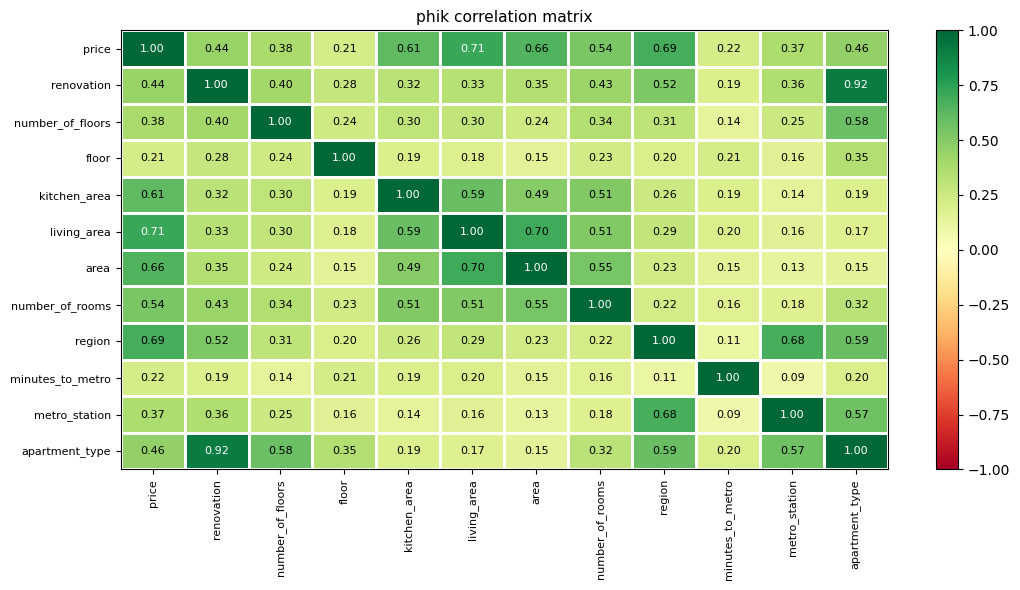

In [10]:
phik_matrix = df.phik_matrix()

plot_correlation_matrix(phik_matrix.values,
                        x_labels = phik_matrix.columns,
                        y_labels = phik_matrix.index,
                        title = 'phik correlation matrix',
                        fontsize_factor=0.8, figsize=(11, 6)
)

In [11]:
automl = TabularAutoML(
    task = Task(
        name = 'reg',
        loss = 'mae',
        metric = lambda y_true, y_pred: 100 / (1 + mape(y_true, y_pred)))
)

In [12]:
oof_pred = automl.fit_predict(
    df,
    roles = {'target': 'price', 'drop': []}
)

In [13]:
test_pred = automl.predict(pred_df)
test_pred

array([[7.0536814],
       [7.5639143],
       [6.9368763],
       ...,
       [7.5433946],
       [7.526246 ],
       [7.5171247]], dtype=float32)

In [14]:
test_pred = np.power(10, test_pred.data[:, 0]) - 1
test_pred

array([11315698., 36636528.,  8647215., ..., 34945768., 33592788.,
       32894604.], dtype=float32)

In [15]:
sample = pd.read_csv('test.csv')['index']
sample

0          0
1          1
2          2
3          3
4          4
        ... 
7587    7587
7588    7588
7589    7589
7590    7590
7591    7591
Name: index, Length: 7592, dtype: int64

In [16]:
df1 = pd.DataFrame({
    'index':sample.index,
    'price': test_pred
}).to_csv('submit.csv', index = False)